In [209]:
import requests
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary
from torchmetrics import Accuracy

In [ ]:
# visualize erros
if Path("helper_function.py").is_file():
    print ('helper function exists')
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [2]:
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise= 0.03, random_state =42)
len(X), len(y)
print (f"First 5 samples of X\n {X[:5]}")
print (f"First 5 samples of y\n {y[:5]}")

First 5 samples of X
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y
 [1 1 1 1 0]


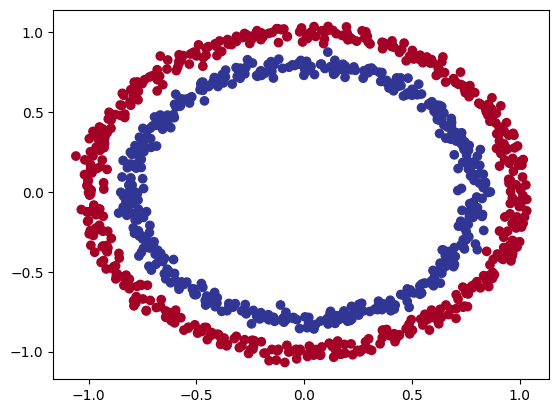

In [3]:
df_circles = pd.DataFrame({"X1": X[:, 0],
                          "X2": X[:, 1],
                          "label": y})

plt.scatter (x = X[:,0],
             y = X[:, 1],
             c = y,
             cmap = plt.cm.RdYlBu);

In [4]:
# print(f'sample x : {X[0]} shape x sample {X[0].shape} y sample, shape {y[0], y[0.shape]}')
print(f'sample x: {X[0]}, shape x sample: {X[0].shape}, y sample: {y[0]}, shape y sample: {y[0].shape}')


sample x: [0.75424625 0.23148074], shape x sample: (2,), y sample: 1, shape y sample: ()


In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [6]:
type (X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [7]:
# train test split using scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [113]:
# create model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features=256)
        self.layer_2 = nn.Linear(in_features = 256, out_features=1)
        self.relu = nn.ReLU()
        
    def forward (self, x):
        return self.relu(self.layer_2(self.layer_1(x)))
    
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [103]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [182]:
# sequential model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features = 16),
    nn.ReLU(),
    # nn.Linear(in_features=8, out_features = 16),
    # nn.ReLU(),
    nn.Linear(in_features= 16, out_features = 1),
    # nn.ReLU()  
    ).to(device)
model_0


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [160]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
        

In [141]:
# untrained predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print (f'Pred len: {len(untrained_preds)} Shape: {untrained_preds.shape}')
print (f'Sample Len: {len(X_test)} Shape {X_test.shape}')
print (f'\First 10 preds : \n {torch.round(untrained_preds[:10])}')
print (f'nFirst 10 labels\n {y_test[:10]}')

Pred len: 200 Shape: torch.Size([200, 1])
Sample Len: 200 Shape torch.Size([200, 2])
\First 10 preds : 
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
nFirst 10 labels
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [4]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimzer = torch.optim.SGD(params =model_0.parameters(),lr= 0.1)

NameError: name 'model_0' is not defined

In [59]:
# calculate accurate
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [129]:
# look at logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
y_logits
    

tensor([[0.0000],
        [0.0000],
        [0.0138],
        [0.0000],
        [0.1293]], device='cuda:0')

In [130]:
# change to probabilities
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs).squeeze(), y_pred_probs.squeeze()

(tensor([0., 0., 1., 0., 1.], device='cuda:0'),
 tensor([0.5000, 0.5000, 0.5034, 0.5000, 0.5323], device='cuda:0'))

In [184]:
# train and test loop
# set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epocs
epochs = 1000

# put data in device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range (epochs):
    #train
    model_0.train()
    
    # forward
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round (torch.sigmoid(y_logits))
    
    # calucate loss
    loss = loss_fn (y_logits,
                    y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred=y_pred)
    
    # optimizer zero grad
    optimzer.zero_grad()
    
    # loss backwards
    loss.backward()
    
    # optimizer step
    optimzer.step()
    
    # 
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_train,
                               y_pred = y_pred) 
        
    #print
    if epoch % 100 == 0:
        print (f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} test_acc {test_acc:.2f}%')
          

Epoch: 0 | Loss: 0.69478, Acc: 52.12% | Test loss: 0.69304 test_acc 52.12%
Epoch: 100 | Loss: 0.68202, Acc: 56.38% | Test loss: 0.68131 test_acc 56.38%
Epoch: 200 | Loss: 0.67488, Acc: 60.00% | Test loss: 0.67532 test_acc 60.00%
Epoch: 300 | Loss: 0.66620, Acc: 65.50% | Test loss: 0.66803 test_acc 65.50%
Epoch: 400 | Loss: 0.65494, Acc: 72.25% | Test loss: 0.65871 test_acc 72.25%
Epoch: 500 | Loss: 0.64014, Acc: 82.25% | Test loss: 0.64694 test_acc 82.25%
Epoch: 600 | Loss: 0.62142, Acc: 91.62% | Test loss: 0.63284 test_acc 91.62%
Epoch: 700 | Loss: 0.59941, Acc: 95.38% | Test loss: 0.61559 test_acc 95.38%
Epoch: 800 | Loss: 0.57391, Acc: 97.50% | Test loss: 0.59483 test_acc 97.50%
Epoch: 900 | Loss: 0.54473, Acc: 98.00% | Test loss: 0.57015 test_acc 98.00%


In [45]:
# visualize erros
if Path("helper_function.py").is_file():
    print ('helper function exists')
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

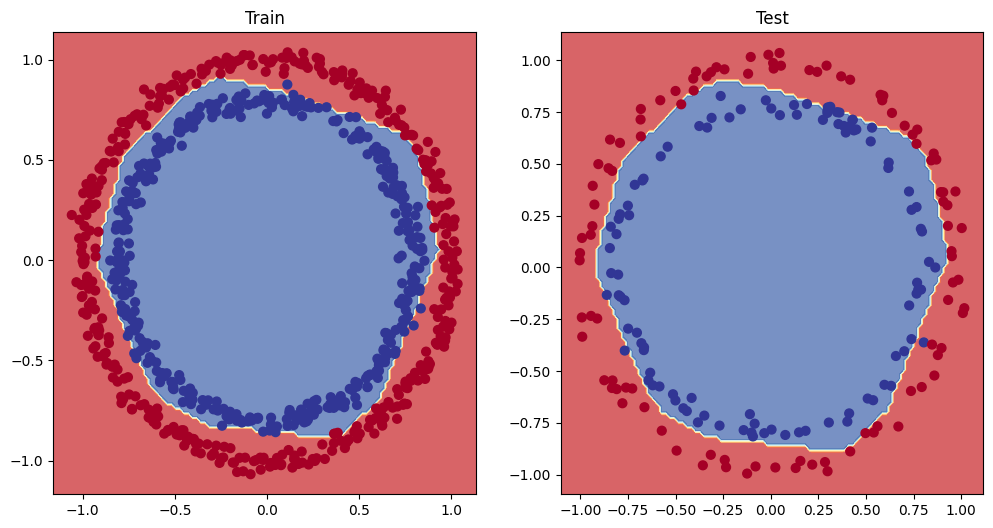

In [185]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot (1,2, 1)
plt.title ("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot (1, 2, 2)
plt.title ("Test")
plot_decision_boundary(model_0, X_test, y_test)

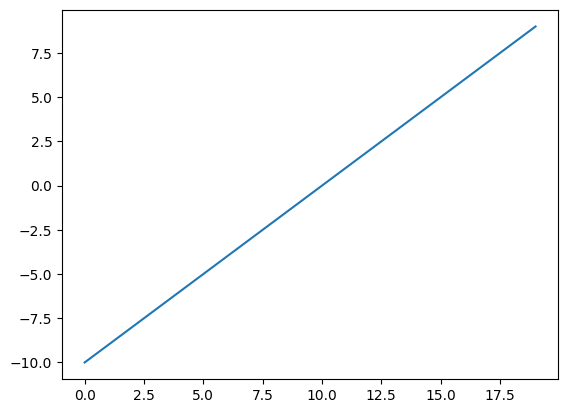

In [3]:
# create tensor
A = torch.arange (-10, 10, 1,dtype=torch.float32)
plt.plot(A)

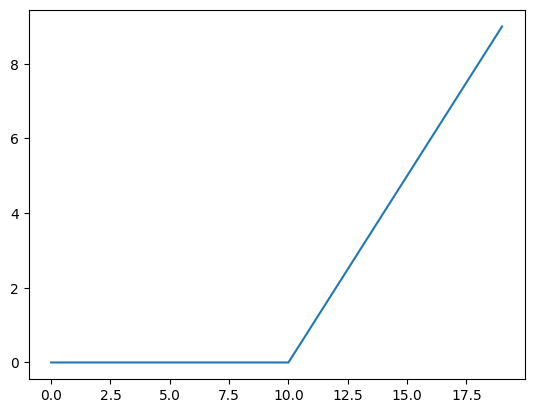

In [4]:
# create resul
def relu (x):
    return torch.maximum(torch.tensor(0),x)
plt.plot (relu(A))

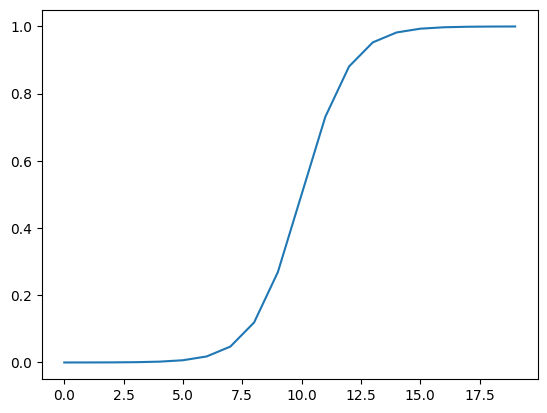

In [5]:
# create and plot sigmoid
def sigmoid(x):
    return (1/(1+torch.exp(-x)))
plt.plot(sigmoid(A))

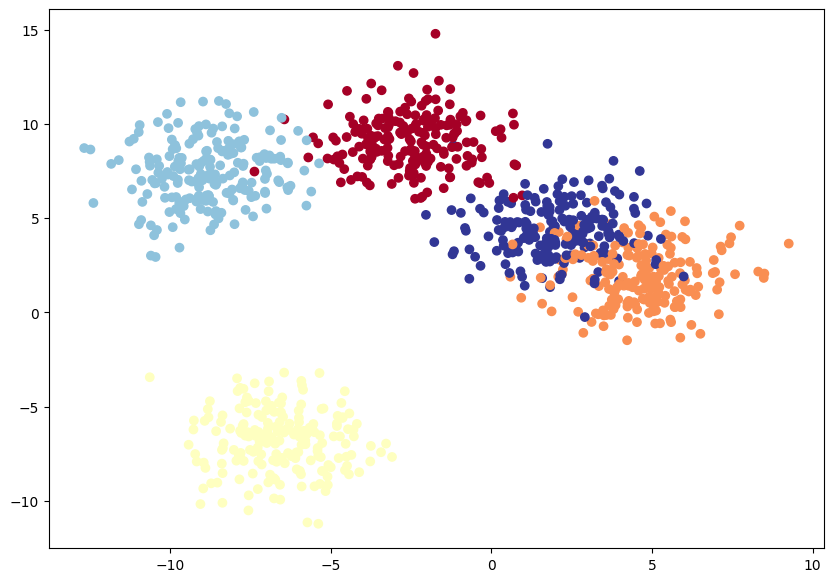

In [74]:
# create multi-class datas
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 42
# create data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5,
                           random_state = RANDOM_SEED)

# convert to torch
X_blob = torch.from_numpy(X_blob).type (torch.float)
y_blob = torch.from_numpy(y_blob).type (torch.LongTensor)
# spit into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        train_size=0.8,
                                                                        random_state = RANDOM_SEED)


# plot data
plt.figure (figsize = (10, 7))

plt.scatter (X_blob[:, 0], X_blob[:,1], c = y_blob, cmap=plt.cm.RdYlBu)



In [91]:
# # device agnostic ode
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# X_blob.requires_grad_(True)
# # y_blob.requires_grad_(True)
# X_blob_train, y_blob_train, X_blob_test, y_blob_test = X_blob_train.to(device), y_blob_train.to(device), X_blob_test.to(device), y_blob_test.to(device)
# # X_blob_train.requires_grad_(True), y_blob_train.requires_grad_(True), X_blob_test.requires_grad_(True), y_blob_test.requires_grad_(True)
# X_blob_train.requires_grad_(True),  X_blob_test.requires_grad_(True)

In [92]:
# multi-class classifiction
# class BlobModel (nn.Module):
#     def __init__ (self, input_features=2, output_features=5, hidden_units = 8):
#         super().__init__()
#         self.linear_layer_stack = nn.Sequential(
#             nn.Linear (in_features = input_features, out_features = hidden_units),
#             # nn.ReLU(),
#             nn.Linear (in_features = hidden_units, out_features = hidden_units),
#             # nn.ReLU(),
#             nn.Linear (in_features = hidden_units, out_features = output_features),
#             # nn.ReLU(),
#         )
        
#     def forward (self, x):
#         return self.linear_layer_stack(x)
    
# model_4 = BlobModel().to(device)
# model_4

In [93]:
# # create model
# class CircleModelV0(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_1 = nn.Linear(in_features = 2, out_features=256)
#         self.layer_2 = nn.Linear(in_features = 256, out_features=1)
#         self.relu = nn.ReLU()
        
#     def forward (self, x):
#         return self.relu(self.layer_2(self.layer_1(x)))
    
    
# model_0 = CircleModelV0().to(device)
# model_0

In [107]:
# # do multi-class in sepeated line
# class BlobModel (nn.Module):
#     def __init__(self, input_features = 2, output_features = 5, hidden_units = 8):
#         super().__init__()
    
#         self.LL_1 = nn.Linear (in_features = input_features, out_features = hidden_units)
#         self.LL_2 = nn.Linear (in_features = hidden_units, out_features = hidden_units)
#         self.LL_3 = nn.Linear (in_features = hidden_units, out_features = output_features)

#         # self.relu = nn.ReLU()

#     def forward (self,x):

#         l1 = self.LL_1 (x)
#         # self.relu(l1)
#         l2 = self.LL_2(l1)
#         # self.relu(l2)
#         l3 = self.LL_3(l2)

#         output = l3
#         return output

    
# model_4 = BlobModel().to(device)
# model_4    




In [120]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [121]:
# # loss function
# # model_4 = BlobModel().to(device)
# for param in model_4.parameters():
#     param.requires_grad = True
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model_4.parameters(), lr = 0.1)

In [143]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [144]:
# for param in model_4.parameters():
#     param.requires_grad = True
for name, param in model_4.named_parameters():
    if param.grad is not None:
        print(f'{name} gradient: {param.grad.norm()}')
# model_4.named_parameters()

In [145]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 1.9128, -1.2230,  2.4414,  2.3222,  0.3391],
        [ 1.4286, -1.3090,  1.8951,  2.0029,  0.2367],
        [ 1.8549,  0.7690,  2.6650,  0.7757,  0.7672],
        [-1.9933, -0.6262, -1.7790, -1.2261, -0.2026],
        [-1.6877, -1.4033, -1.5542, -0.3983, -0.3209]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [146]:
# How many elements in a single prediction sample?
# model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([5]), 5)

In [153]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 1.9128, -1.2230,  2.4414,  2.3222,  0.3391],
        [ 1.4286, -1.3090,  1.8951,  2.0029,  0.2367],
        [ 1.8549,  0.7690,  2.6650,  0.7757,  0.7672],
        [-1.9933, -0.6262, -1.7790, -1.2261, -0.2026],
        [-1.6877, -1.4033, -1.5542, -0.3983, -0.3209]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [160]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([5]), 5)

In [167]:
# # testd code fo prediction
# test_pred = torch.argmax(torch.softmax((model_4(X_blob_test).squeeze()), dim = 1), dim =1).long()
# test_pred, y_blob_test.long()
# X_blob_test
# y_blob_train
# Make prediction logits with model
# y_logits = model_4(X_blob_test.to(device))

# # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
# y_pred_probs = torch.softmax(y_logits, dim=1) 
# print(y_logits[:5])
# print(y_pred_probs[:5])

In [168]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0980, -1.7942,  0.1420,  1.1572, -0.1330],
        [-1.4380, -0.8049, -1.1926, -0.6510, -0.1462],
        [-1.4167, -0.9777, -1.1940, -0.5040, -0.1806],
        [ 2.0993,  0.6144,  2.9121,  1.0861,  0.7753],
        [-0.6035, -1.9071, -0.4315,  0.8413, -0.2449]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1443, 0.0265, 0.1835, 0.5064, 0.1394],
        [0.1000, 0.1884, 0.1278, 0.2197, 0.3640],
        [0.1027, 0.1594, 0.1284, 0.2559, 0.3536],
        [0.2433, 0.0551, 0.5485, 0.0883, 0.0647],
        [0.1230, 0.0334, 0.1461, 0.5215, 0.1760]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [169]:
# Sum the first sample output of the softmax activation function 
# torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [174]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [175]:
# Which class does the model think is *most* likely at the index 0 sample?
# print(y_pred_probs[0])
# print(torch.argmax(y_pred_probs[0]))

tensor([0.1443, 0.0265, 0.1835, 0.5064, 0.1394], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [179]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1443, 0.0265, 0.1835, 0.5064, 0.1394], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [180]:
y_pred = torch.argmax(torch.softmax(model_4(X_blob_train), dim = 1), dim = 1).float()
y_logits = model_4(X_blob_train)
y_pred[:4], y_logits [:4]

(tensor([2., 3., 2., 4.], device='cuda:0'),
 tensor([[ 1.9128, -1.2230,  2.4414,  2.3222,  0.3391],
         [ 1.4286, -1.3090,  1.8951,  2.0029,  0.2367],
         [ 1.8549,  0.7690,  2.6650,  0.7757,  0.7672],
         [-1.9933, -0.6262, -1.7790, -1.2261, -0.2026]], device='cuda:0',
        grad_fn=<SliceBackward0>))

In [183]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
y_logits = model_4(X_blob_train) 
y_blob_train[:4], y_logits [:4]

(tensor([3, 3, 2, 1], device='cuda:0'),
 tensor([[ 1.9128, -1.2230,  2.4414,  2.3222,  0.3391],
         [ 1.4286, -1.3090,  1.8951,  2.0029,  0.2367],
         [ 1.8549,  0.7690,  2.6650,  0.7757,  0.7672],
         [-1.9933, -0.6262, -1.7790, -1.2261, -0.2026]], device='cuda:0',
        grad_fn=<SliceBackward0>))

In [ ]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# epochs = 1000
# # X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
# # X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
# X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
# X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# # Ensure y_blob_train is a LongTensor
# # y_blob_train = y_blob_train.float()
# # y_blob_test = y_blob_test.float()

# for epoch in range (epochs):
#     # model_4.train()
#     model_4.train()
#     # get predictions
#     y_pred = torch.argmax(torch.softmax(model_4(X_blob_train), dim = 1), dim = 1).float()
#     # calculate loss
#     loss = loss_fn (y_pred.float().requires_grad_(), y_blob_train.float().requires_grad_())
#     # print (f'loss requires grad {loss.requires_grad}  y_pred: {y_pred.float().requires_grad}, y_blob {y_blob_train.float().requires_grad}')
    
#     # grad zero
#     # optimizer.zero_grad()
#     optimizer.zero_grad()
    
#     # backward loss
#     # loss.backward()
#     loss.backward()
    
#     # optimizer ste
#     optimizer.step()
    
#     model_4.eval()
#     with torch.inference_mode():
#         # test_pred = model_4(X_blob_test).squeeze()
#         test_pred = torch.argmax(torch.softmax(model_4(X_blob_test), dim = 1), dim = 1).float()
#         test_loss = loss_fn (test_pred.float(), y_blob_test.float())
        
#     if epoch % 100 == 0:
#         print (f'epoch" {epoch}| Loss: {loss:.5f}, | Test Loss {test_loss:.5f}')
        

In [198]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# epochs = 1000
# # X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
# # X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
# X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
# X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Ensure y_blob_train is a LongTensor
# y_blob_train = y_blob_train.float()
# y_blob_test = y_blob_test.float()

torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


# for epoch in range (epochs):
#     # model_4.train()
#     model_4.train()
for epoch in range(epochs):
    ### Training
    model_4.train()
    # get predictions
    # y_pred = torch.argmax(torch.softmax(model_4(X_blob_train), dim = 1), dim = 1).float()
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    
    
    # # calculate loss
    # loss = loss_fn (y_pred.float().requires_grad_(), y_blob_train.float().requires_grad_())
    loss = loss_fn(y_logits, y_blob_train) 
    # print (f'ylogit:{y_logits[:4]}, y_blob_train[:4]')
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)




    # grad zero
    # optimizer.zero_grad()
    optimizer.zero_grad()
    
    # backward loss
    # loss.backward()
    loss.backward()
    
    # optimizer ste
    optimizer.step()
    
    model_4.eval()
    with torch.inference_mode():
        # test_pred = model_4(X_blob_test).squeeze()
        test_logits = model_4(X_blob_test)
        test_pred = torch.argmax(torch.softmax(model_4(X_blob_test), dim = 1), dim = 1).float()
        # test_loss = loss_fn (test_pred.float(), y_blob_test.float())
        test_loss = loss_fn (test_logits, y_blob_test)
        
    if epoch % 10 == 0:
        print (f'epoch" {epoch}| Loss: {loss:.5f}, | Test Loss {test_loss:.5f}')
        

epoch" 0| Loss: 0.17834, | Test Loss 0.17424
epoch" 10| Loss: 0.17789, | Test Loss 0.17385
epoch" 20| Loss: 0.17746, | Test Loss 0.17347
epoch" 30| Loss: 0.17703, | Test Loss 0.17311
epoch" 40| Loss: 0.17661, | Test Loss 0.17275
epoch" 50| Loss: 0.17619, | Test Loss 0.17240
epoch" 60| Loss: 0.17578, | Test Loss 0.17205
epoch" 70| Loss: 0.17538, | Test Loss 0.17172
epoch" 80| Loss: 0.17498, | Test Loss 0.17139
epoch" 90| Loss: 0.17458, | Test Loss 0.17107


In [194]:
    ### Training
model_4.train()
# get predictions
# y_pred = torch.argmax(torch.softmax(model_4(X_blob_train), dim = 1), dim = 1).float()
y_logits = model_4(X_blob_train) # model outputs raw logits 
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels



# # calculate loss
# loss = loss_fn (y_pred.float().requires_grad_(), y_blob_train.float().requires_grad_())
loss = loss_fn(y_logits, y_blob_train) 
print (f'ylogit:{y_logits[:4]}, y_blob {y_blob_train[:4]}')


ylogit:tensor([[  9.5429, -25.2350,  19.3072,  24.9265,  -7.3647],
        [  9.3062, -21.3741,  13.5514,  20.0483,  -4.8819],
        [ -6.3241, -11.8768,  30.7940,  19.0374, -13.2028],
        [ -2.5749,  14.2225, -19.2769, -17.8454,   8.7090]], device='cuda:0',
       grad_fn=<SliceBackward0>), y_blob tensor([3, 3, 2, 1], device='cuda:0')


In [200]:
model_4.eval()
with torch.inference_mode():
    y_test_logit = torch.softmax(model_4(X_blob_train), dim = 1).argmax(dim = 1)

In [204]:
X_blob_train[:4], y_blob_train[:4]

(tensor([[-10.5935,   4.6206],
         [ -8.8228,   5.3558],
         [ -6.5671,  -9.9427],
         [  6.1493,   1.1078]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([3, 3, 2, 1], device='cuda:0'))

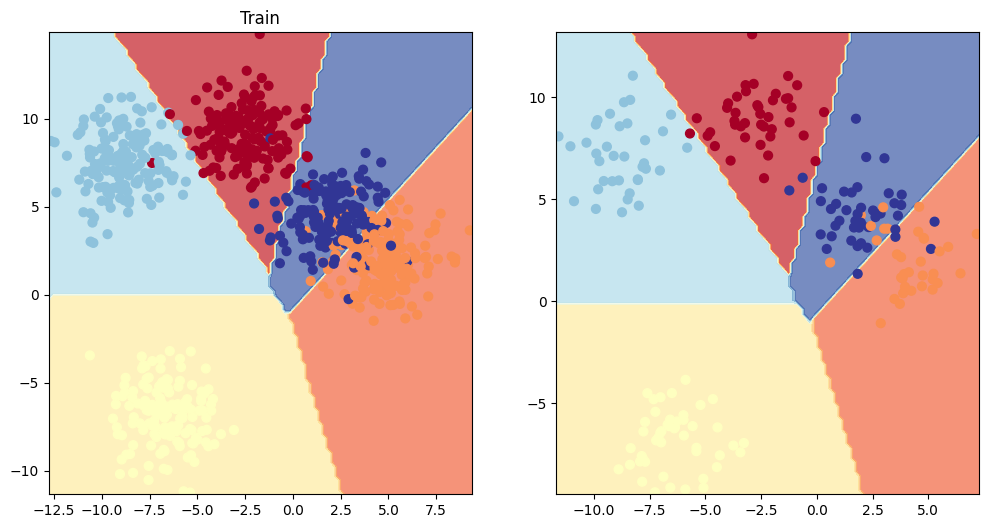

In [205]:
plt.figure (figsize=(12, 6))
plt.subplot(1,2,1)
plt.title ('Train')
plot_decision_boundary(model_4, X_blob_train.detach(), y_blob_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_4, X_blob_test.detach(), y_blob_test)


In [218]:
# Turn predicted logits in prediction probabilities
X_blob_test.to(device)
model_4.to(device)
y_pred_probs = torch.softmax(model_4(X_blob_test), dim = 1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)
torchmet_acc = Accuracy(task='multiclass', num_classes=5).to(device)
torchmet_acc(y_preds, y_blob_test)

tensor(0.9250, device='cuda:0')

In [212]:
y_test_logit[:4]

tensor([3, 3, 2, 1], device='cuda:0')